In [6]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib import cm
from matplotlib.font_manager import FontProperties
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable, grad
from torch.nn.functional import binary_cross_entropy_with_logits as bce
import h5py


#import GenInput, DelphesFunctions, logistics

#These are a bunch of functions I wrote to generate the data and sample it properly when normalized/unnormalized
from DelphesFunctions import load_electron_data, sample_delphes_array#, specific_delphes_sample
from GenInput import eParticle_gun_with_noise_eta_bound as big_gun
from GenInput import sample_gun_data as gun
from logistics import feature_unnormalize, feature_normalize
import os
import imageio
try:
    import cPickle as pickle
except ImportError:
    import pickle
## make pyroot_dataset_egun a callable function! Just make an init.py and a class to call for it to make/load the data

### Description of Data

I preprocessed the data so that all of the physic software could be avoided and someone can run this script with just some compressed numpy files. An overview:

- normalized data is normalized feature by feature, with each having $\mu = 0$ and $\sigma = 1$

- **unnormed pythia data**: this is the ground truth events (eta, phi, PT) that are perfect and ideal. unnormalized. The events are electrons fired uniformally random in a direction on the unit sphere. **Note**: eta is not a normal angle. It is a relativistically correlated one. As such, there will be fewer extreme values of $\eta$ because $\eta =  -\ln\tan{\frac{\theta}{2}}$
- **p_angles** = these are the angles (eta,phi) of the pythia events in a separate variables for your use.
- **unnormed_delphes_data**: this is data from delphes, which has some built in detector inefficiencies. It may fail to recognize the exact PT, smearing it in some way. Moreover, there are efficiency cuts.
- **delphes_data**: Normalized delphes data.
- **delphes_means_stds**: These are the means and stds for each column of the delphes data ($\eta$, $\phi$, $P_{T}$)
- **pythia_data**: The normalized pythia data.
- **pythia_means_stds**: The means and stds for each column of the pythia data ($\eta$, $\phi$, $P_{T}$)

In [40]:


#This will take a minute

#filename = '/home/chris/Documents/MPhilProjects/GANs/delphes_gun/1million_electron.root'

#load all the data to sample from in training, and unnormed version for plotting later
#delphes_data, delphes_means_stds = load_electron_data(filename)
#unnormed_delphes_data, _ = load_electron_data(filename, Normalized=False)

#pythia_data, gen_angles, pythia_means_stds = big_gun(Normalized = False)
#unnormed_pythia_data, p_angles, _ = big_gun(Normalized=False)
unnormed_pythia_data = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/unnormed_pythia_data.npz')['arr_0']
p_angles = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/unnormed_pythia_angles.npz')['arr_0']
unnormed_delphes_data = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/unnormed_delphes_data.npz')['arr_0']
delphes_data = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/normed_delphes_data.npz')['arr_0']
delphes_means_stds = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/delphes_means_stds.npz')['arr_0']
#pythia_data, pythia_means_stds = feature_normalize(unnormed_pythia_data)
pythia_data = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/normed_pythia_data.npz')['arr_0']
pythia_means_stds = np.load('/home/chris/Documents/MPhilProjects/MyGANs/data/dataForDavid/pythia_means_stds.npz')['arr_0']



In [17]:
#Definte Network Architecture
class Perceptron(torch.nn.Module):
    def __init__(self, sizes, final=None):
        super(Perceptron, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i != (len(sizes) - 2):
                layers.append(torch.nn.ReLU())
        if final is not None:
            layers.append(final())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
    

In [23]:

    
#### This is all for plotting

def plot(epoch, n_events, plot_eta = True):
    
    n_events = 500

    # make normalized pythia tensor sample of electrons to run through generator at specific eta ranges
    pythia_eta_03, eta_phi_03 = gun(pythia_data, bs=n_events, eta_center = 0.3, tensor=True, angles=p_angles)
    pythia_eta_16, eta_phi_16 = gun(pythia_data, bs=n_events, eta_center = 1.6, tensor=True, angles=p_angles)
    pythia_eta_25, eta_phi_25 = gun(pythia_data, bs=n_events, eta_center = 2.5, tensor=True, angles=p_angles)
    #print eta_phi_03[:,0].min(), eta_phi_03[:,0].max(), eta_phi_03.shape
    
    # get delphes samples in same ranges, the eta 2.5 range will have very few events so just 
    # take as many as appear in pythia for that
    delphes_eta_03 = sample_delphes_array(unnormed_delphes_data, eta_center=0.3, bs=n_events, tensor=False)
    delphes_eta_16 = sample_delphes_array(unnormed_delphes_data, eta_center=1.6, bs=n_events, tensor=False)
    delphes_eta_25 = sample_delphes_array(unnormed_delphes_data, eta_center=2.5, bs=len(pythia_eta_25[:,2]), tensor=False)
    
    #make unnormed pythia data for later plotting use
    unnormed_pythia_eta_03, _ = gun(unnormed_pythia_data, bs=n_events, eta_center = 0.3, tensor=True, angles=p_angles)
    #test np.concatenate((eta_phi_03, gen_eta_03),1)
    unnormed_pythia_eta_16, _ = gun(unnormed_pythia_data, bs=n_events, eta_center = 1.6, tensor=True, angles=p_angles)
    unnormed_pythia_eta_25, _ = gun(unnormed_pythia_data, bs=n_events, eta_center = 2.5, tensor=True, angles=p_angles)
    
    
    #### Run through the Generator and concatenate with angles again for plotting later, then unnorm
    gen_output_eta_03 = netG(pythia_eta_03).cpu().data.numpy()
    angles_gen_output_03 = np.concatenate((eta_phi_03.cpu().data.numpy(), gen_output_eta_03), 1)
    unnormed_gen_output_eta_03 = feature_unnormalize(angles_gen_output_03, pythia_means_stds)


    gen_output_eta_16 = netG(pythia_eta_16).cpu().data.numpy()
    angles_gen_output_16 = np.concatenate((eta_phi_16.cpu().data.numpy(), gen_output_eta_16), 1)
    unnormed_gen_output_eta_16 = feature_unnormalize(angles_gen_output_16, pythia_means_stds)


    gen_output_eta_25 = netG(pythia_eta_25).cpu().data.numpy()
    angles_gen_output_25 = np.concatenate((eta_phi_25.cpu().data.numpy(), gen_output_eta_25), 1)
    unnormed_gen_output_eta_25 = feature_unnormalize(angles_gen_output_25, pythia_means_stds)

    #### Plot them (weighted PT in each eta range)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
    ax1.hist(delphes_eta_03[:,0], weights=delphes_eta_03[:,2], bins=np.arange(0.18,0.43,.01), label='delphes')
    ax1.hist(unnormed_gen_output_eta_03[:,0], weights=unnormed_gen_output_eta_03[:,2], bins=np.arange(0.18,0.43,.01), 
         label='generator', alpha=0.5)
    ax2.hist(delphes_eta_16[:,0], weights=delphes_eta_16[:,2], bins=np.arange(1.48,1.73,.01), label='delphes', alpha=0.5)
    ax2.hist(unnormed_gen_output_eta_16[:,0], weights=unnormed_gen_output_eta_16[:,2], bins=np.arange(1.48,1.73,.01), 
         label='generator', alpha=0.5)
    ax3.hist(delphes_eta_25[:,0], weights=delphes_eta_25[:,2], bins=np.arange(2.38,2.63,.01), label='delphes', alpha=0.5)
    ax3.hist(unnormed_gen_output_eta_25[:,0], weights=unnormed_gen_output_eta_25[:,2], bins=np.arange(2.38,2.63,.01), 
         label='pythia', alpha=0.5)
    
    ax1.set_title(r' 0.2 < $(\eta)$ < 0.4 ')
    ax1.set_ylabel(r'Count, Weighted by $P_{T}$ (MeV)')
    ax2.set_title(r' 1.5 < $(\eta)$ < 1.7 ')
    ax3.set_title(r' 2.4 < $(\eta)$ < 2.6 ')
    
    ax1.legend(loc='best')
    ax1.legend(bbox_to_anchor=[4, 0.5], loc='center right')
    fig.text(0.5, -0.05,r' Pseudorapidity $(\eta)$', ha='center', fontsize=14)
    plt.show()
    
    ######################
    
    ## Plot the PT distributions in each of the specified eta ranges to see if they are learning the different
    ## smearing and efficiency cuts
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
    ax1.hist(delphes_eta_03[:,2], label = 'delphes', bins = np.arange(0,15000,500), alpha=0.7)
    ax1.hist(unnormed_gen_output_eta_03[:,2], label= 'generator', bins = np.arange(0,15000,500), alpha =0.7)

    ax2.hist(delphes_eta_16[:,2], bins = np.arange(0,15000,500), label='delphes', alpha=0.7)
    ax2.hist(unnormed_gen_output_eta_16[:,2], bins = np.arange(0,15000,500), label='generator', alpha=0.7)

    ax3.hist(delphes_eta_25[:,2], bins = np.arange(0,15000,500), label='delphes', alpha=0.7)
    ax3.hist(unnormed_gen_output_eta_25[:,2], bins = np.arange(0,15000,500), label='pythia', alpha=0.7)

    ax1.set_title(r' 0.2 < $(\eta)$ < 0.4 ')
    ax1.set_ylabel('Count')
    ax2.set_title(r' 1.5 < $(\eta)$ < 1.7 ')
    ax3.set_title(r' 2.4 < $(\eta)$ < 2.6 ')

    ax1.legend(loc='best')
    ax1.legend(bbox_to_anchor=[4, 0.5], loc='center right')
    fig.text(0.5, -0.05,r' Transverse Momentum $P_{T}$ (MeV)', ha='center', fontsize=14)
    plt.ylim(0,300)
    plt.show()

    
    #####################
    
    ## Plot the Difference in PT Between Delphes and True Pythia, and The Difference in PT between Generator and Pythia
    ## Do this for specific eta ranges to see if it is learning the smearing that is different in each range
    ## Then plot it for all data across eta
    
    delphes_03_diff = delphes_eta_03[:,2] - unnormed_pythia_eta_03[:,2].cpu().data.numpy()

    delphes_16_diff = delphes_eta_16[:,2] - unnormed_pythia_eta_16[:,2].cpu().data.numpy()
    delphes_25_diff = delphes_eta_25[:142,2] - unnormed_pythia_eta_25[:142,2].cpu().data.numpy()

    gen_03_diff = unnormed_gen_output_eta_03[:,2] - unnormed_pythia_eta_03[:,2].cpu().data.numpy()
    gen_16_diff = unnormed_gen_output_eta_16[:,2] - unnormed_pythia_eta_16[:,2].cpu().data.numpy()
    gen_25_diff = unnormed_gen_output_eta_25[:142,2] - unnormed_pythia_eta_25[:142,2].cpu().data.numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
    ax1.hist(delphes_03_diff, label = 'delphes', bins = np.arange(-5000,5000,200), alpha = 0.7) 
    ax1.hist(gen_03_diff, label= 'generator', bins = np.arange(-5000,5000,200), alpha =0.7) 
    ax1.set_title(r' 0.2 < $(\eta)$ < 0.4 ')
    ax2.hist(delphes_16_diff, bins = np.arange(-5000,5000,200), alpha = 0.7) 
    ax2.hist(gen_16_diff, bins = np.arange(-5000,5000,200), alpha = 0.7)
    ax2.set_title(r' 1.5 < $(\eta)$ < 1.7 ')
    ax3.hist(delphes_25_diff, bins = np.arange(-5000,5000,200), alpha = 0.7)
    ax3.hist(gen_25_diff, bins = np.arange(-5000,5000,200), alpha = 0.7) 
    ax3.set_title(r' 2.4 < $(\eta)$ < 2.6 ')
    ax1.legend(loc='best')
    ax1.legend(bbox_to_anchor=[4, 0.5], loc='center right')
    fig.text(0.5, -0.05,r' Difference in $P_{T}$ (MeV) between Delphes/GAN and Ground Truth', ha='center', fontsize=14)
    plt.ylim(0,200)
    plt.show()
    
    PTDiff_plot_filename =  'PTDiff_EGunPTSmearingWCPercetronGAN_' + Layer_type +'_'+ str(n_layers) + "Layers_" + str(n_hidden)  \
            +"hiddenPerLayer_" + str(bs) + "BatchSize_" + str(n_iterations) + "Epochs_" + str(int(lamD)) \
            +"LambPenalty_" + str(extraD) + "ExtraD"
    
    pythia_full_sample, eta_phi_full = gun(pythia_data, bs=68000, tensor=True, angles=p_angles);
    unnormed_pythia_full_sample, _ = gun(unnormed_pythia_data, bs=68000, tensor=True, angles=p_angles);
    gen_output_eta_all = netG(pythia_full_sample).cpu().data.numpy();
    angles_gen_output_all = np.concatenate((eta_phi_full.cpu().data.numpy(), gen_output_eta_all), 1);
    unnormed_gen_output_eta_all = feature_unnormalize(angles_gen_output_all, pythia_means_stds);
    delphes_eta_all = sample_delphes_array(unnormed_delphes_data, bs=68000, tensor=False)

    
    delphes_residuals = ((delphes_eta_all[:,2] - unnormed_pythia_full_sample.cpu().data.numpy()[:,2]))# / 
                     #np.sqrt(np.linalg.norm(unnormed_pythia_full_sample.cpu().data.numpy()[:,2])))
    generator_residuals = ((unnormed_gen_output_eta_all[:,2] - unnormed_pythia_full_sample.cpu().data.numpy()[:,2]))# / 
                     #np.sqrt(np.linalg.norm(unnormed_pythia_full_sample.cpu().data.numpy()[:,2])))
    fig = plt.figure(figsize=(9,7))
    bins = np.arange(-7500, 7500,100)
    plt.hist(delphes_residuals, bins = bins, alpha = 0.9, label = 'delphes');
    plt.hist(generator_residuals, bins = bins, alpha = 0.8, label = 'generator');
    plt.title(r"$P_{T}$ difference between Pythia and Delphes, and Pythia and Generator " + str(epoch))
    plt.title(r" $e^{-}$ $P_{T}$ difference between Pythia and Delphes/Generator, Epoch " + str(epoch), 
              fontsize = 13.5)
    plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    plt.ylabel("Count")
    plt.ylim(0,7000)
    plt.legend(loc='best')
    #plt.savefig("/home/chris/Documents/MPhilProjects/ForViewing/plots/GifTest/eGun/" + str(epoch) + ".png")
    plt.show()
    
    

    ################################
    
    
    ## If true, make a plot of eta values weighted by their PT to make sure they also follow a Delphes-Like distribution
    
    if plot_eta == True:
        
        eta_plot_filename =  'Eta_EGunPTSmearingWCPercetronGAN_' + Layer_type +'_'+ str(n_layers) + "Layers_" + str(n_hidden)  \
            +"hiddenPerLayer_" + str(bs) + "BatchSize_" + str(n_iterations) + "Epochs_" + str(int(lamD)) \
            +"LambPenalty_" + str(extraD) + "ExtraD"
            
        
        fig= plt.figure(figsize=(9,7))
        plt.hist(unnormed_pythia_full_sample.cpu().data.numpy()[:,0], weights = unnormed_pythia_full_sample.cpu().data.numpy()[:,2], 
                 bins= np.arange(-3,3,0.1), alpha=0.6, label='true pythia')
        plt.hist(delphes_eta_all[:,0], weights = delphes_eta_all[:,2], bins= np.arange(-3,3,0.1), 
                 alpha=0.95, label='delphes', color = 'yellow');
        plt.hist(unnormed_gen_output_eta_all[:,0], weights=unnormed_gen_output_eta_all[:,2], 
                 bins= np.arange(-3,3,0.1), alpha=0.5, label = 'generator', color = 'black');
        plt.title(r"Weighted Histogram of $e^{-}$ $P_{T}$ Smearing by Delphes and Generator, Epoch" + str(epoch), fontsize=13.5)
        plt.xlabel(r' Pseudorapidity ($\eta$)', fontsize=12)
        plt.ylabel(r' Count Weighted by $P_{T}$')
        plt.legend(loc='best')
        #plt.savefig("/home/chris/Documents/MPhilProjects/ForViewing/plots/" + eta_plot_filename)

    
    return

In [35]:

#Choosing a CUDA device to run on
torch.cuda.set_device(1)
print "Number of Cuda Devices Available: ", torch.cuda.device_count()
print "Cuda device: ", torch.cuda.current_device()


n_iterations =2000
n_latent = 1
n_layers = 2
n_hidden = 256
bs = 512
shape = 'ring'
lamD = 60.
extraD = 10
wgan = False
verbose = True
v_freq = 1000
n_conditional = 3 #eta and phi and PT
Layer_type = 'ReLU'
gamma = 0.1

netD = Perceptron([3] + [n_hidden] * n_layers + [1])
netG = Perceptron([n_latent + n_conditional] + [n_hidden] * n_layers + [1])
netD.cuda()
netG.cuda()
print netD
print netG
optD = torch.optim.Adam(netD.parameters())
optG = torch.optim.Adam(netG.parameters())



p_real = sample_delphes_array(delphes_data, 1000)

p_nois_conds, gen_angles = gun(pythia_data, bs=1000)


Number of Cuda Devices Available:  3
Cuda device:  1
Perceptron(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=256)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1)
  )
)
Perceptron(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1)
  )
)


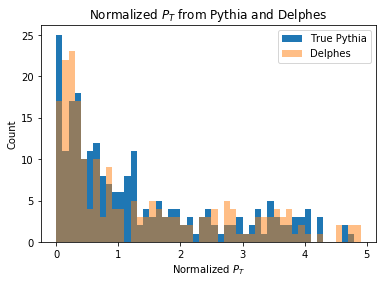

In [36]:
plt.hist(p_nois_conds.cpu().data.numpy()[:,2], bins=np.arange(0,5,0.1), label='True Pythia');
plt.hist(p_real.cpu().data.numpy()[:,2], bins = np.arange(0,5,0.1), alpha =0.5, label = 'Delphes');
plt.title(r'Normalized $P_{T}$ from Pythia and Delphes')
plt.xlabel(r'Normalized $P_{T}$')
plt.ylabel('Count')
plt.legend(loc='best')

### Notes on the Roth GAN regularizer

The JS-Regularization from Roth and Nowozin defined as: 

![text](JS-Regularizer.jpg "Title")

I need to work out the correct pytorch implementation of this. I have been trying to translate it from tensorflow, but the "tf.gradients" function seems to behave a bit differently. 

In [37]:
def objective_wgan(fakeD, realD):
    return fakeD.mean() - realD.mean()


def objective_gan(fakeD, realD):
    labD = torch.cat((torch.ones(fake.size(0), 1) - 1e-3,
                      torch.zeros(real.size(0), 1) + 1e-3)).cuda()
    #print " HERE IS THE LABD", fakeD.cpu().data.numpy()
    return bce(torch.cat((fakeD, realD)), Variable(labD))

def roth_reg(disc_real_logits, real_data, disc_fake_logits, fake_data):
    D1 = torch.sigmoid(disc_real_logits)
    D2 = torch.sigmoid(disc_fake_logits)
    print (disc_real_logits*bs).size(), real_data.size()
    grad_real_logits = grad(disc_real_logits, real_data, create_graph=True)[0]
    grad_fake_logits = grad(disc_fake_logits, fake_data, create_graph=True)[0]
    #grad_real_logits = tf.gradients(disc_real_logits, real_data)[0]
    #grad_fake_logits = tf.gradients(disc_fake_logits, real_data)[0]
    grad_real_logits_norm = torch.norm( grad_real_logits , axis=1)
    grad_fake_logits_norm = torch.norm( grad_fake_logits , axis=1)
    #grad_D1_logits_norm = tf.norm( tf.reshape(grad_D1_logits, [BATCH_SIZE//len(DEVICES),-1]) , axis=1)
    #grad_D2_logits_norm = tf.norm( tf.reshape(grad_D2_logits, [BATCH_SIZE//len(DEVICES),-1]) , axis=1)

    #set keep_dims=True/False such that grad_D_logits_norm.shape == D.shape
    print('grad_real_logits_norm.shape {} != D1.shape {}'.format(grad_real_logits_norm.shape, D1.shape))
    print('grad_fake_logits_norm.shape {} != D2.shape {}'.format(grad_fake_logits_norm.shape, D2.shape))
    assert grad_real_logits_norm.shape == D1.shape
    assert grad_fake_logits_norm.shape == D2.shape
    
    reg_D1 = torch.mul(torch.mul(1.0-D1, 1.0-D1), torch.mul(grad_real_logits_norm,grad_real_logits_norm))
    reg_D2 = torch.mul(torch.mul(1.0-D2, 1.0-D2), torch.mul(grad_fake_logits_norm,grad_fake_logits_norm))

#     reg_D1 = tf.multiply(tf.square(1.0-D1), tf.square(grad_real_logits_norm))
#     reg_D2 = tf.multiply(tf.square(D2), tf.square(grad_fake_logits_norm))

    disc_regularizer = torch.mean(reg_D1 + reg_D2)
            
    return disc_regularizer

A Jupyter Widget

Epoch #1: Generative Loss: -0.587411224842, Discriminative Loss: 0.594093263149


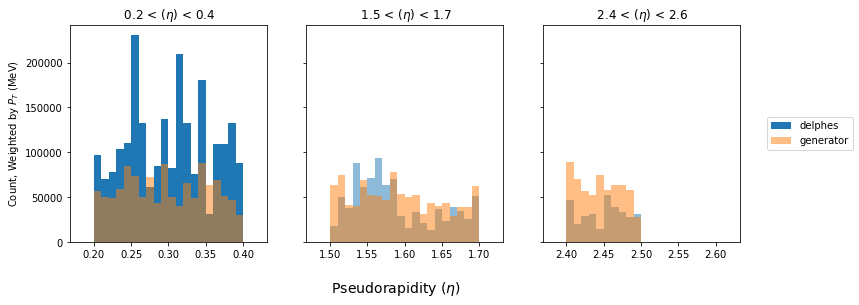

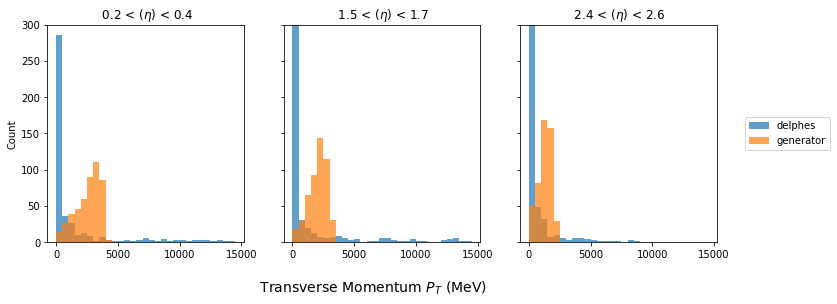

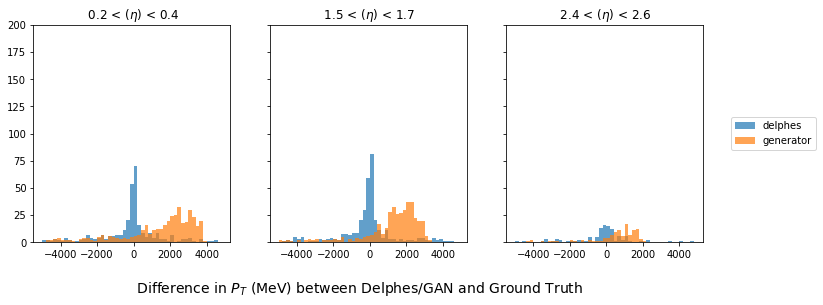

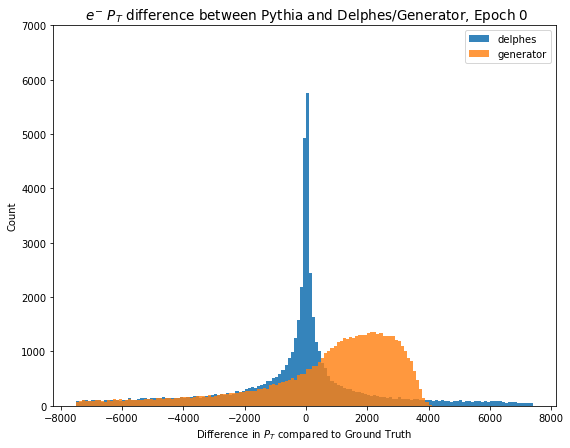

Epoch #1001: Generative Loss: -0.664070248604, Discriminative Loss: 0.657911479473


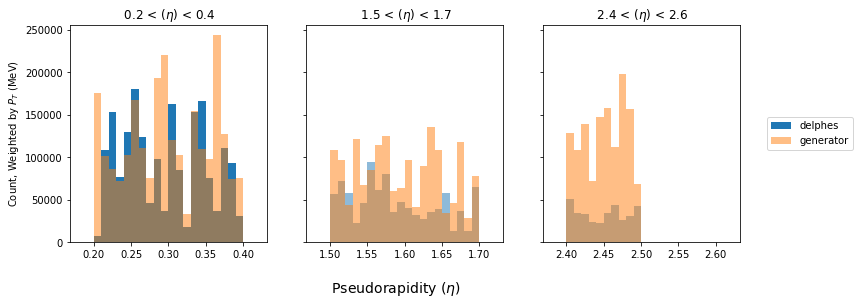

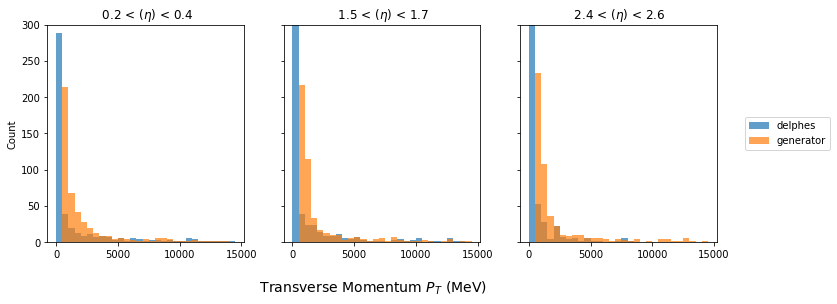

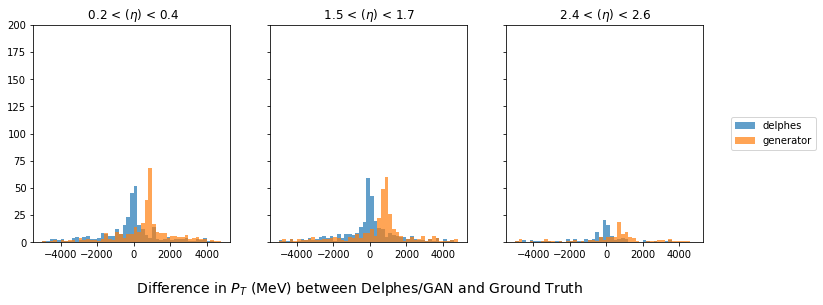

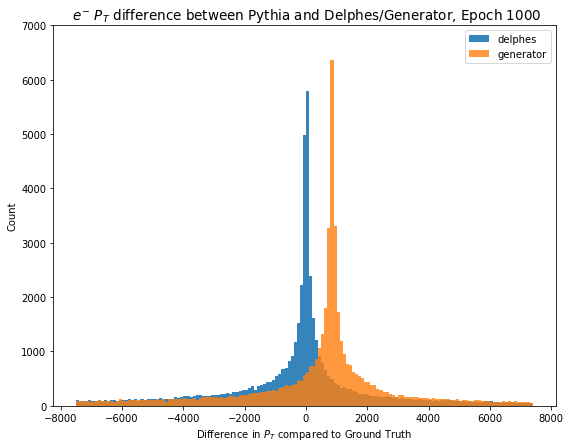

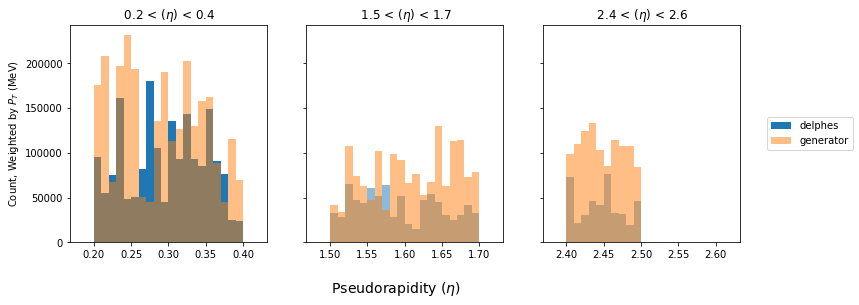

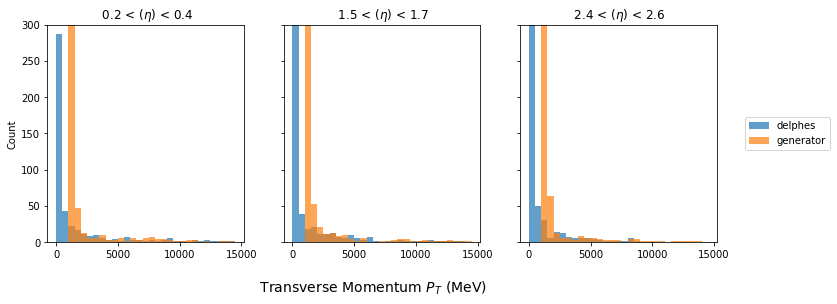

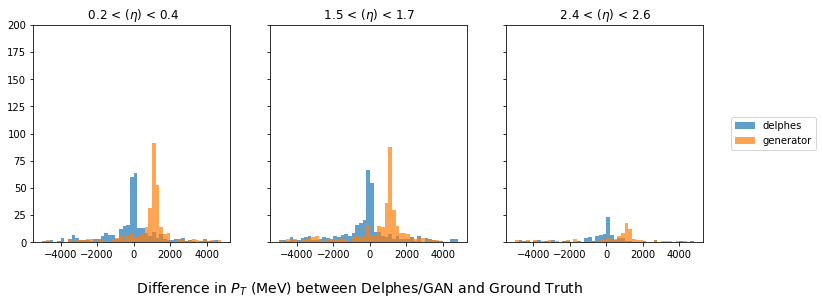

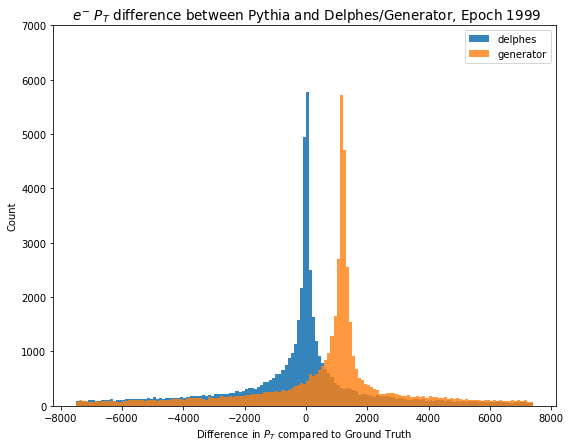

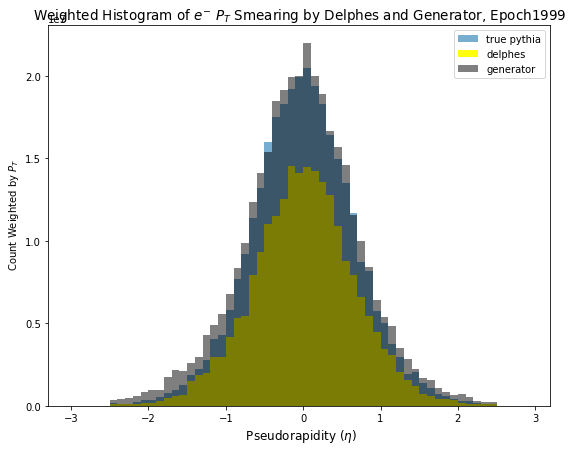

In [38]:
objective = objective_wgan if wgan else objective_gan

iter_range = range(n_iterations)

#print out time information if verbose is True
if verbose:
    iter_range = tqdm(iter_range)


for iteration in iter_range:
    for extra in range(extraD):
        real = sample_delphes_array(delphes_data, bs)
        gen_input, angles = gun(pythia_data, bs=bs)
        fake = netG(gen_input)
        fake_disc_input = torch.cat((angles,fake), 1)
        #data = torch.cat((fake, real), 0)

        optD.zero_grad()
        
        # take normal objective loss
        lossD = objective(netD(real), netD(fake_disc_input))
        gradD = grad(lossD * bs, fake_disc_input, create_graph=True)[0]
        
        #### UNCOMMENT FOR ROTH GAN
        #regularize on discriminator
        #reguD = roth_reg(netD(real).squeeze_(), real, netD(fake_disc_input).squeeze_(), fake_disc_input)
        #assert lossD.shape ==reguD.shape
        #lossD += (gamma/2.0)*reguD
        
        #improved training of wasserstein gans, add the reguD gradient penalty term, then backpropagate
        reguD = gradD.norm(2, 1).clamp(1).mean()
        (lossD).backward()
        optD.step()

    real = sample_delphes_array(delphes_data, bs)
    gen_input, angles = gun(pythia_data, bs=bs)
    fake = netG(gen_input)
    fake_disc_input = torch.cat((angles,fake), 1)

    optG.zero_grad()
    lossG = - objective(netD(real), netD(fake_disc_input))
    (lossG).backward()
    optG.step()

    if (iteration % v_freq) == 0:
        print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(iteration + 1, lossG.data[0], lossD.data[0]))
        plot(iteration, n_events = 500, plot_eta = False)
    
    if (n_iterations - 1) == iteration:
        plot(iteration, n_events = 500, plot_eta = True)
    

        

        
        
        
MakeGif = False
gif_filename =  'EGunPTSmearingWCPercetronGAN_GIF_' + Layer_type +'_'+ str(n_layers) + "Layers_" + str(n_hidden)  \
            +"hiddenPerLayer_" + str(bs) + "BatchSize_" + str(n_iterations) + "Epochs_" + str(int(lamD)) \
            +"LambPenalty_" + str(extraD) + "ExtraD.gif"
        
if MakeGif == True:
    png_dir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/GifTest/eGun/"
    images = []
    for subdir, dirs, files in os.walk(png_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file_path.endswith(".png"):
                images.append(imageio.imread(file_path))
    imageio.mimsave(gif_filename, images)



In [ ]:
# Do you want to save a pickle of the Generator and Discriminator? Then run this script

with open('SmearingGan.pkl', 'wb') as f:
        pickle.dump({'G': netG, 'D': netD}, f)

-49880.0678596


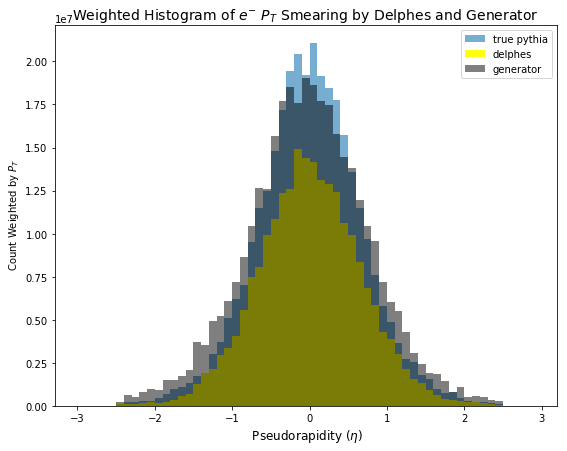

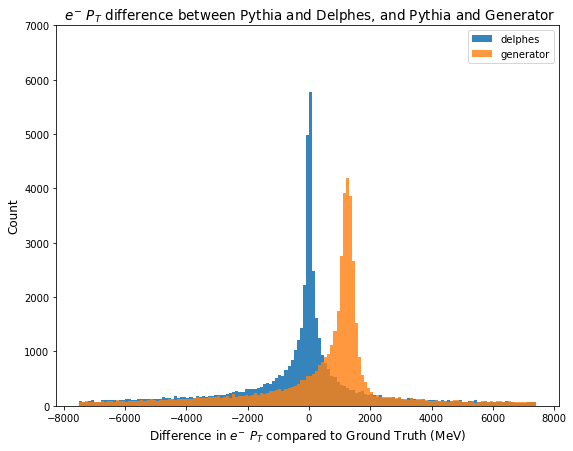

In [16]:
batch = 68000
#filename = 'EGunPTSmearingWGAN' + str(batch) + 'Events_' + str(n_iterations) + 'Iterations.png'
eta_plot_filename =  'Eta_EGunPTSmearingWCPercetronGAN_' + Layer_type +'_'+ str(n_layers) + "Layers_" + str(n_hidden)  \
            +"hiddenPerLayer_" + str(bs) + "BatchSize_" + str(n_iterations) + "Epochs_" + str(int(lamD)) \
            +"LambPenalty_" + str(extraD) + "ExtraD"
        
PTDiff_plot_filename =  'PTDiff_EGunPTSmearingWCPercetronGAN_' + Layer_type +'_'+ str(n_layers) + "Layers_" + str(n_hidden)  \
            +"hiddenPerLayer_" + str(bs) + "BatchSize_" + str(n_iterations) + "Epochs_" + str(int(lamD)) \
            +"LambPenalty_" + str(extraD) + "ExtraD"

pythia_full_sample, eta_phi_full = gun(pythia_data, bs=68000, tensor=True, angles=p_angles);
unnormed_pythia_full_sample, _ = gun(unnormed_pythia_data, bs=68000, tensor=True, angles=p_angles);
gen_output_eta_all = netG(pythia_full_sample).cpu().data.numpy();
angles_gen_output_all = np.concatenate((eta_phi_full.cpu().data.numpy(), gen_output_eta_all), 1);
unnormed_gen_output_eta_all = feature_unnormalize(angles_gen_output_all, pythia_means_stds);
delphes_eta_all = sample_delphes_array(unnormed_delphes_data, bs=68000, tensor=False)





fig= plt.figure(figsize=(9,7))
plt.hist(unnormed_pythia_full_sample.cpu().data.numpy()[:,0], weights = unnormed_pythia_full_sample.cpu().data.numpy()[:,2], 
         bins= np.arange(-3,3,0.1), alpha=0.6, label='true pythia')
plt.hist(delphes_eta_all[:,0], weights = delphes_eta_all[:,2], bins= np.arange(-3,3,0.1), 
         alpha=0.95, label='delphes', color = 'yellow');
plt.hist(unnormed_gen_output_eta_all[:,0], weights=unnormed_gen_output_eta_all[:,2], 
         bins= np.arange(-3,3,0.1), alpha=0.5, label = 'generator', color = 'black');
plt.title(r"Weighted Histogram of $e^{-}$ $P_{T}$ Smearing by Delphes and Generator", fontsize=14)
plt.xlabel(r' Pseudorapidity ($\eta$)', fontsize=12)
plt.ylabel(r' Count Weighted by $P_{T}$')
plt.legend(loc='best')
#plt.savefig("/home/chris/Documents/MPhilProjects/ForViewing/plots/" + eta_plot_filename)
#plot();


## plot PT differences between delphes and truth and generator and truth
delphes_residuals = ((delphes_eta_all[:,2] - unnormed_pythia_full_sample.cpu().data.numpy()[:,2]))# / 
                     #np.sqrt(np.linalg.norm(unnormed_pythia_full_sample.cpu().data.numpy()[:,2])))
generator_residuals = ((unnormed_gen_output_eta_all[:,2] - unnormed_pythia_full_sample.cpu().data.numpy()[:,2]))# / 
                     #np.sqrt(np.linalg.norm(unnormed_pythia_full_sample.cpu().data.numpy()[:,2])))
fig = plt.figure(figsize=(9,7))
bins = np.arange(-7500, 7500,100)
plt.hist(delphes_residuals, bins = bins, alpha = 0.9, label = 'delphes');
plt.hist(generator_residuals, bins = bins, alpha = 0.8, label = 'generator');
plt.title(r" $e^{-}$ $P_{T}$ difference between Pythia and Delphes, and Pythia and Generator", fontsize = 13.5)
plt.xlabel(r"Difference in $e^{-}$ $P_{T}$ compared to Ground Truth (MeV)", fontsize = 12)
plt.ylabel("Count", fontsize=12)
plt.ylim(0,7000)
plt.legend(loc='best')
#plt.savefig("/home/chris/Documents/MPhilProjects/ForViewing/plots/" + PTDiff_plot_filename)

print delphes_residuals.min()

Variable containing:
 0.2360
[torch.cuda.FloatTensor of size 1 (GPU 1)]
 Variable containing:
 0.4732
[torch.cuda.FloatTensor of size 1 (GPU 1)]
 torch.Size([2000, 2])


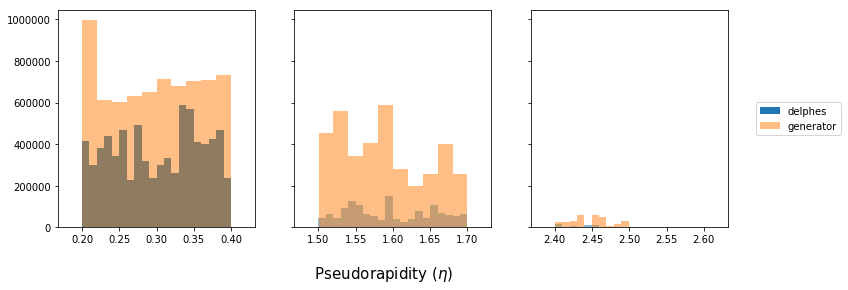

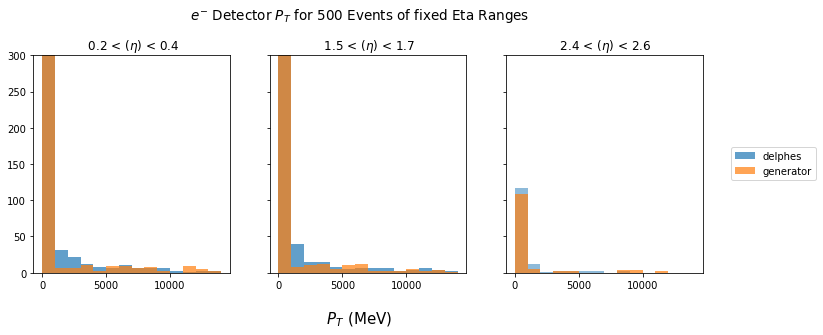

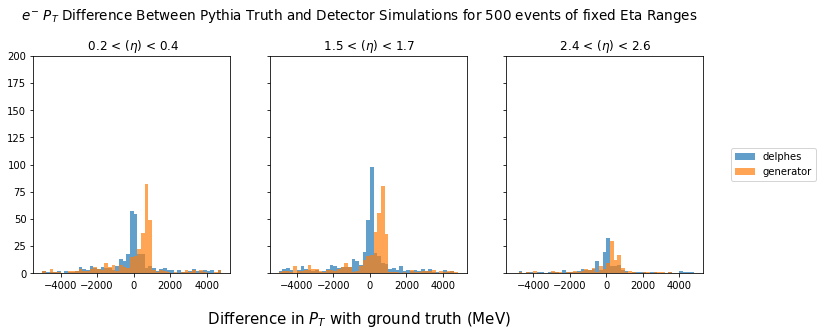

In [337]:

n_events = 500

pythia_eta_03, eta_phi_03 = gun(pythia_data, bs=n_events, eta_center = 0.3, tensor=True, angles=p_angles)
#test np.concatenate((eta_phi_03, gen_eta_03),1)
pythia_eta_16, eta_phi_16 = gun(pythia_data, bs=n_events, eta_center = 1.6, tensor=True, angles=p_angles)
pythia_eta_25, eta_phi_25 = gun(pythia_data, bs=n_events, eta_center = 2.5, tensor=True, angles=p_angles)


unnormed_pythia_eta_03, _ = gun(unnormed_pythia_data, bs=n_events, eta_center = 0.3, tensor=True, angles=p_angles)
#test np.concatenate((eta_phi_03, gen_eta_03),1)
unnormed_pythia_eta_16, _ = gun(unnormed_pythia_data, bs=n_events, eta_center = 1.6, tensor=True, angles=p_angles)
unnormed_pythia_eta_25, _ = gun(unnormed_pythia_data, bs=n_events, eta_center = 2.5, tensor=True, angles=p_angles)



delphes_eta_03 = sample_delphes_array(unnormed_delphes_data, eta_center=0.3, bs=n_events, tensor=False)
delphes_eta_16 = sample_delphes_array(unnormed_delphes_data, eta_center=1.6, bs=n_events, tensor=False)
delphes_eta_25 = sample_delphes_array(unnormed_delphes_data, eta_center=2.5, bs=len(pythia_eta_25[:,2]), tensor=False)
#print eta_phi_03[:,0].min(), eta_phi_03[:,0].max(), eta_phi_03.shape

gen_output_eta_03 = netG(pythia_eta_03).cpu().data.numpy()
angles_gen_output_03 = np.concatenate((eta_phi_03.cpu().data.numpy(), gen_output_eta_03), 1)
unnormed_gen_output_eta_03 = feature_unnormalize(angles_gen_output_03, pythia_means_stds)


gen_output_eta_16 = netG(pythia_eta_16).cpu().data.numpy()
angles_gen_output_16 = np.concatenate((eta_phi_16.cpu().data.numpy(), gen_output_eta_16), 1)
unnormed_gen_output_eta_16 = feature_unnormalize(angles_gen_output_16, pythia_means_stds)


gen_output_eta_25 = netG(pythia_eta_25).cpu().data.numpy()
angles_gen_output_25 = np.concatenate((eta_phi_25.cpu().data.numpy(), gen_output_eta_25), 1)
unnormed_gen_output_eta_25 = feature_unnormalize(angles_gen_output_25, pythia_means_stds)


#####################
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
ax1.hist(delphes_eta_03[:,2], label = 'delphes', bins = np.arange(0,15000,1000), alpha=0.7)
ax1.hist(unnormed_gen_output_eta_03[:,2], label= 'generator', bins = np.arange(0,15000,1000), alpha =0.7)

ax2.hist(delphes_eta_16[:,2], bins = np.arange(0,15000,1000), label='delphes', alpha=0.7)
ax2.hist(unnormed_gen_output_eta_16[:,2], bins = np.arange(0,15000,1000), label='generator', alpha=0.7)

ax3.hist(delphes_eta_25[:,2], bins = np.arange(0,15000,1000), label='delphes', alpha=0.5)
ax3.hist(unnormed_gen_output_eta_25[:,2], bins = np.arange(0,15000,1000), label='pythia', alpha=0.7)

ax1.set_title(r' 0.2 < $(\eta)$ < 0.4 ')
ax2.set_title(r' 1.5 < $(\eta)$ < 1.7 ')
ax3.set_title(r' 2.4 < $(\eta)$ < 2.6 ')

ax1.legend(loc='best')
ax1.legend(bbox_to_anchor=[4, 0.5], loc='center right')
fig.text(0.5, -0.05,r' $P_{T}$ (MeV)', ha='center', fontsize=15)
fig.suptitle(r" $e^{-}$ Detector $P_{T}$ for 500 Events of fixed Eta Ranges", 
             fontsize = 13.5, x = 0.5, y = 1.05)
plt.ylim(0,300)
plt.show()


######################

delphes_03_diff = delphes_eta_03[:,2] - unnormed_pythia_eta_03[:,2].cpu().data.numpy()

delphes_16_diff = delphes_eta_16[:,2] - unnormed_pythia_eta_16[:,2].cpu().data.numpy()
delphes_25_diff = delphes_eta_25[:142,2] - unnormed_pythia_eta_25[:142,2].cpu().data.numpy()

gen_03_diff = unnormed_gen_output_eta_03[:,2] - unnormed_pythia_eta_03[:,2].cpu().data.numpy()
gen_16_diff = unnormed_gen_output_eta_16[:,2] - unnormed_pythia_eta_16[:,2].cpu().data.numpy()
gen_25_diff = unnormed_gen_output_eta_25[:,2] - unnormed_pythia_eta_25[:,2].cpu().data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
ax1.hist(delphes_03_diff, label = 'delphes', bins = np.arange(-5000,5000,200), alpha = 0.7) #bins=np.arange(0.18,0.43,.01), label='delphes')
ax1.hist(gen_03_diff, label= 'generator', bins = np.arange(-5000,5000,200), alpha =0.7) #bins=np.arange(0.18,0.43,.01), 
ax1.set_title(r' 0.2 < $(\eta)$ < 0.4 ')
ax2.hist(delphes_16_diff, bins = np.arange(-5000,5000,200), alpha = 0.7) #bins=np.arange(1.48,1.73,.01), label='delphes', alpha=0.5)
ax2.hist(gen_16_diff, bins = np.arange(-5000,5000,200), alpha = 0.7)#, bins=np.arange(1.48,1.73,.01)
ax2.set_title(r' 1.5 < $(\eta)$ < 1.7 ')
ax3.hist(delphes_25_diff, bins = np.arange(-5000,5000,200), alpha = 0.7)# bins=np.arange(2.38,2.63,.01), label='delphes', alpha=0.5)
ax3.hist(gen_25_diff, bins = np.arange(-5000,5000,200), alpha = 0.7)# bins=np.arange(2.38,2.63,.01), 
ax3.set_title(r' 2.4 < $(\eta)$ < 2.6 ')
ax1.legend(loc='best')
ax1.legend(bbox_to_anchor=[4, 0.5], loc='center right')
fig.text(0.5, -0.05,r' Difference in $P_{T}$ with ground truth (MeV)', ha='center', fontsize=15)
fig.suptitle(r" $e^{-}$ $P_{T}$ Difference Between Pythia Truth and Detector Simulations for " +str(n_events) +  " events of fixed Eta Ranges ", 
             fontsize = 13.5, x = 0.5, y = 1.05)
plt.ylim(0,200)
plt.show()

In [22]:
# normal_pythia_eta_03 = Variable(torch.from_numpy(feature_normalize(pythia_eta_03, 
#                                                  given_means_stds=pythia_means_stds)[0]).type(torch.FloatTensor).cuda())
# normalized_eta_03_angles = normal_pythia_eta_03[:,:2].cpu().data.numpy()
# gen_output_eta_03 = netG(normal_pythia_eta_03).cpu().data.numpy()
# angles_gen_output_03 = np.concatenate((normalized_eta_03_angles, gen_output_eta_03), 1)
# unnormed_gen_output_eta_03 = feature_unnormalize(angles_gen_output_03, pythia_means_stds)


# normal_pythia_eta_16 = Variable(torch.from_numpy(feature_normalize(pythia_eta_16, 
#                                                  given_means_stds=pythia_means_stds)[0]).type(torch.FloatTensor).cuda())
# normalized_eta_16_angles = normal_pythia_eta_16[:,:2].cpu().data.numpy()
# gen_output_eta_16 = netG(normal_pythia_eta_16).cpu().data.numpy()
# angles_gen_output_16 = np.concatenate((normalized_eta_16_angles, gen_output_eta_16), 1)
# unnormed_gen_output_eta_16 = feature_unnormalize(angles_gen_output_16, pythia_means_stds)


# normal_pythia_eta_25 = Variable(torch.from_numpy(feature_normalize(pythia_eta_25, 
#                                                  given_means_stds=pythia_means_stds)[0]).type(torch.FloatTensor).cuda())
# normalized_eta_25_angles = normal_pythia_eta_25[:,:2].cpu().data.numpy()
# gen_output_eta_25 = netG(normal_pythia_eta_25).cpu().data.numpy()
# angles_gen_output_25 = np.concatenate((normalized_eta_25_angles, gen_output_eta_25), 1)
# unnormed_gen_output_eta_25 = feature_unnormalize(angles_gen_output_25, pythia_means_stds)


# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
# ax1.hist(delphes_eta_03[:,0], weights=delphes_eta_03[:,2], bins=np.arange(0.18,0.43,.01), label='delphes')
# ax1.hist(unnormed_gen_output_eta_03[:,0], weights=unnormed_gen_output_eta_03[:,2], bins=np.arange(0.18,0.43,.01), 
#          label='generator', alpha=0.5)
# ax2.hist(delphes_eta_16[:,0], weights=delphes_eta_16[:,2], bins=np.arange(1.48,1.73,.01), label='delphes', alpha=0.5)
# ax2.hist(unnormed_gen_output_eta_16[:,2],  bins=np.arange(1.48,1.73,.01), 
#          label='generatore', alpha=0.5)
# ax3.hist(delphes_eta_25[:,0], weights=delphes_eta_25[:,2], bins=np.arange(2.38,2.63,.01), label='delphes', alpha=0.5)
# ax3.hist(unnormed_gen_output_eta_25[:,0], weights=unnormed_gen_output_eta_25[:,2], bins=np.arange(2.38,2.63,.01), 
#          label='pythia', alpha=0.5)
# ax1.legend(loc='best')
# ax1.legend(bbox_to_anchor=[4, 0.5], loc='center right')
# fig.text(0.5, -0.05,r' Pseudorapidity $(\eta)$', ha='center', fontsize=15)